# Hyperparameter optimization and displaying models output

In this Notebook, we show the different steps through which our three models ShallowModel, DeepModel and DeepModelWS are optimized with respect to their hyperparameters. Then, for the best combination of parameters, we display the evolution of model output with respect to the epoch number.

In [5]:

from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/Deep Learning/Proj1"


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Deep Learning/Proj1


In [6]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch import Tensor
from torch import nn
from torch import cuda

import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import dlc_practical_prologue as prologue

from models import *
from helpers import *

In [7]:
nb_samples = 1000
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb_samples)

# work on GPU if device is available
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)
print("Using device " + device_name)
train_input, train_target, train_classes, test_input, test_target, test_classes = train_input.to(device), train_target.to(device), train_classes.to(device), test_input.to(device), test_target.to(device), test_classes.to(device)

print('train_input', train_input.size(), 'train_classes', train_classes.size(), 'train_target', train_target.size())
print('test_input', test_input.size(), 'test_classes', test_classes.size(), 'test_target', test_target.size())

Using device cuda
train_input torch.Size([1000, 2, 14, 14]) train_classes torch.Size([1000, 2]) train_target torch.Size([1000])
test_input torch.Size([1000, 2, 14, 14]) test_classes torch.Size([1000, 2]) test_target torch.Size([1000])


## Hyperparameters which are optimized:
During this task, we fix the optimizer and the number of epochs to Adam and 25 respectively. As for the hyperparameters tested, below is the list:

*   learning rate
*   mini batch size
*   number of hidden layers
*   auxiliary loss weight (only for DeepModel and DeepModelWS)

In [8]:
nb_trials = 10
# parameters to be tested
optimizers = [optim.Adam]
nb_epochs = [25]
lrs = [5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3, 2e-3, 3e-3, 4e-3, 5e-3] # [1e-4, 1e-2] were also tried
mini_batch_sizes = [100] # [1,250,1000] # best is always 1
nb_hiddens = [100,300,500] 
auxiliary_loss_weights = [0,0.25,0.5,0.75,1] # best output for weight = 0.5 when mini_batch_size = 1

In [9]:
TRAIN_MODEL_DEEP = False # Switch to True to retrain the models.
LOAD_PICKLE_DEEP = True  # Switch to False to ignore loading pickle.

if LOAD_PICKLE_DEEP == True:
  test_accuracies_deep = torch.load('data/pickles/deep/test_accuracies.pt')
else:
  test_accuracies_deep = torch.zeros(len(optimizers), len(nb_epochs), len(lrs), len(mini_batch_sizes), len(nb_hiddens), len(auxiliary_loss_weights))
# Hyperparameter optimization grid search for DeepModel
if TRAIN_MODEL_DEEP == True:
  with tqdm(total=len(optimizers)*len(nb_epochs)*len(lrs)*len(mini_batch_sizes)*len(nb_hiddens)*len(auxiliary_loss_weights)*nb_trials) as pbar:
    for i,optimizer in enumerate(optimizers):
      for j,nb_epoch in enumerate(nb_epochs):
        for k,lr in enumerate(lrs):
          for l,mini_batch_size in enumerate(mini_batch_sizes):
            for m,nb_hidden in enumerate(nb_hiddens):
              for n,auxiliary_loss_weight in enumerate(auxiliary_loss_weights):
                if test_accuracies_deep[i,j,k,l,m,n] == 0:
                  trial_test_accuracies = torch.zeros(nb_trials)
                  for trial in range(nb_trials):
                    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb_samples)
                    train_input, train_target, train_classes, test_input, test_target, test_classes = train_input.to(device), train_target.to(device), train_classes.to(device), test_input.to(device), test_target.to(device), test_classes.to(device)
                    deep = DeepModel(nb_hidden, nb_epoch, lr, mini_batch_size, auxiliary_loss_weight).to(device)
                    acc_losses, train_accuracy, test_accuracy, train_error, test_error = deep.train_model(train_input, train_classes,
                                                                                                          train_target, test_input,
                                                                                                          test_target)
                    trial_test_accuracies[trial] = torch.max(test_accuracy)
                    pbar.update(1)
                  test_accuracies_deep[i,j,k,l,m,n] = torch.mean(trial_test_accuracies).item()
                  torch.save(test_accuracies_deep,'data/pickles/deep/test_accuracies.pt')

In [10]:
max_index = (test_accuracies_deep == torch.max(test_accuracies_deep)).nonzero(as_tuple=True)
i,j,k,l,m,n = max_index
optimizer_deep = optimizers[i]
nb_epoch_deep = nb_epochs[j]
lr_deep = lrs[k]
mini_batch_size_deep = mini_batch_sizes[l]
nb_hidden_deep = nb_hiddens[m]
auxiliary_loss_weight_deep = auxiliary_loss_weights[n]
print("Best test accuracy for DeepModel is {}, obtained by the following parameters:".format(test_accuracies_deep[max_index]))
print("optimizer = {0}, nb_epoch = {1}, lr = {2}, mini_batch_size = {3}, nb_hidden = {4}, auxiliary_loss_weight = {5}".format(optimizer_deep, nb_epoch_deep, lr_deep, mini_batch_size_deep, nb_hidden_deep, auxiliary_loss_weight_deep))

Best test accuracy for DeepModel is tensor([79.7800]), obtained by the following parameters:
optimizer = <class 'torch.optim.adam.Adam'>, nb_epoch = 25, lr = 0.005, mini_batch_size = 100, nb_hidden = 100, auxiliary_loss_weight = 0


In [12]:
TRAIN_MODEL_DEEP_WS = False # Switch to True to retrain the models.
LOAD_PICKLE_DEEP_wS = True  # Switch to False to ignore loading pickle.

if LOAD_PICKLE_DEEP_wS == True:
  test_accuracies_deep_ws = torch.load('data/pickles/deep_ws/test_accuracies.pt')
else:
  test_accuracies_deep_ws = torch.zeros(len(optimizers), len(nb_epochs), len(lrs), len(mini_batch_sizes), len(nb_hiddens), len(auxiliary_loss_weights))
# Hyperparameter optimization grid search for DeepModelWS
if TRAIN_MODEL_DEEP_WS == True:
  with tqdm(total=len(optimizers)*len(nb_epochs)*len(lrs)*len(mini_batch_sizes)*len(nb_hiddens)*len(auxiliary_loss_weights)*nb_trials) as pbar:
    for i,optimizer in enumerate(optimizers):
      for j,nb_epoch in enumerate(nb_epochs):
        for k,lr in enumerate(lrs):
          for l,mini_batch_size in enumerate(mini_batch_sizes):
            for m,nb_hidden in enumerate(nb_hiddens):
              for n,auxiliary_loss_weight in enumerate(auxiliary_loss_weights):
                if test_accuracies_deep_ws[i,j,k,l,m,n] == 0:
                  trial_test_accuracies = torch.zeros(nb_trials)
                  for trial in range(nb_trials):
                    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb_samples)
                    train_input, train_target, train_classes, test_input, test_target, test_classes = train_input.to(device), train_target.to(device), train_classes.to(device), test_input.to(device), test_target.to(device), test_classes.to(device)
                    deep_ws = DeepModelWS(nb_hidden, nb_epoch, lr, mini_batch_size, auxiliary_loss_weight).to(device)
                    acc_losses, train_accuracy, test_accuracy, train_error, test_error = deep_ws.train_model(train_input, train_classes,
                                                                                                          train_target, test_input,
                                                                                                          test_target)
                    trial_test_accuracies[trial] = torch.max(test_accuracy)
                    pbar.update(1)
                  test_accuracies_deep_ws[i,j,k,l,m,n] = torch.mean(trial_test_accuracies).item()
                  torch.save(test_accuracies_deep_ws,'data/pickles/deep_ws/test_accuracies.pt')

In [13]:
max_index = (test_accuracies_deep_ws == torch.max(test_accuracies_deep_ws)).nonzero(as_tuple=True)
i,j,k,l,m,n = max_index
optimizer_deep_ws = optimizers[i]
nb_epoch_deep_ws = nb_epochs[j]
lr_deep_ws = lrs[k]
mini_batch_size_deep_ws = mini_batch_sizes[l]
nb_hidden_deep_ws = nb_hiddens[m]
auxiliary_loss_weight_deep_ws = auxiliary_loss_weights[n]
print("Best test accuracy for DeepModelWS is {}, obtained by the following parameters:".format(test_accuracies_deep_ws[max_index]))
print("optimizer = {0}, nb_epoch = {1}, lr = {2}, mini_batch_size = {3}, nb_hidden = {4}, auxiliary_loss_weight = {5}".format(optimizer_deep_ws, nb_epoch_deep_ws, lr_deep_ws, mini_batch_size_deep_ws, nb_hidden_deep_ws, auxiliary_loss_weight_deep_ws))

Best test accuracy for DeepModelWS is tensor([83.2600]), obtained by the following parameters:
optimizer = <class 'torch.optim.adam.Adam'>, nb_epoch = 25, lr = 0.005, mini_batch_size = 100, nb_hidden = 500, auxiliary_loss_weight = 0


In [14]:
TRAIN_MODEL_SHALLOW = True # Switch to True to retrain the models.
LOAD_PICKLE_SHALLOW = False  # Switch to False to ignore loading pickle.

if LOAD_PICKLE_SHALLOW == True:
  test_accuracies_shallow = torch.load('data/pickles/shallow/test_accuracies.pt')
else:
  test_accuracies_shallow = torch.zeros(len(optimizers), len(nb_epochs), len(lrs), len(mini_batch_sizes), len(nb_hiddens))
# Hyperparameter optimization grid search for ShallowModel
if TRAIN_MODEL_SHALLOW == True:
  with tqdm(total=len(optimizers)*len(nb_epochs)*len(lrs)*len(mini_batch_sizes)*len(nb_hiddens)*nb_trials) as pbar:
    for i,optimizer in enumerate(optimizers):
      for j,nb_epoch in enumerate(nb_epochs):
        for k,lr in enumerate(lrs):
          for l,mini_batch_size in enumerate(mini_batch_sizes):
            for m,nb_hidden in enumerate(nb_hiddens):
              if test_accuracies_shallow[i,j,k,l,m] == 0:
                trial_test_accuracies = torch.zeros(nb_trials)
                for trial in range(nb_trials):
                  train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb_samples)
                  train_input, train_target, train_classes, test_input, test_target, test_classes = train_input.to(device), train_target.to(device), train_classes.to(device), test_input.to(device), test_target.to(device), test_classes.to(device)
                  shallow = ShallowModel(nb_hidden, nb_epoch, lr, mini_batch_size).to(device)
                  acc_losses, train_accuracy, test_accuracy, train_error, test_error = shallow.train_model(train_input, train_target, test_input, test_target)
                  trial_test_accuracies[trial] = torch.max(test_accuracy)
                  pbar.update(1)
                test_accuracies_shallow[i,j,k,l,m] = torch.mean(trial_test_accuracies).item()
                torch.save(test_accuracies_shallow,'data/pickles/shallow/test_accuracies.pt')

In [15]:
max_index = (test_accuracies_shallow == torch.max(test_accuracies_shallow)).nonzero(as_tuple=True)
i,j,k,l,m = max_index
optimizer_shallow = optimizers[i]
nb_epoch_shallow = nb_epochs[j]
lr_shallow = lrs[k]
mini_batch_size_shallow = mini_batch_sizes[l]
nb_hidden_shallow = nb_hiddens[m]
print("Best test accuracy for ShallowModel is {}, obtained by the following parameters:".format(test_accuracies_shallow[max_index]))
print("optimizer = {0}, nb_epoch = {1}, lr = {2}, mini_batch_size = {3}, nb_hidden = {4}".format(optimizer_shallow, nb_epoch_shallow, lr_shallow, mini_batch_size_shallow, nb_hidden_shallow))

Best test accuracy for ShallowModel is tensor([77.7200]), obtained by the following parameters:
optimizer = <class 'torch.optim.adam.Adam'>, nb_epoch = 25, lr = 0.0007, mini_batch_size = 100, nb_hidden = 500


## Model output evolution
During this task, we set the best hyperparameter combination for each one of the models. Then, for a set number of trials, we generate random train and test datasets and retrain each model. Finally, we study the evolution of the train and test accuracies as well as the loss in function of the epochs and their variation between trials.

In [18]:
nb_trials = 10
LOAD_PERFORMANCE_DEEP = True
if LOAD_PERFORMANCE_DEEP == False:
  trial_test_accuracies_deep = torch.zeros(nb_trials, nb_epoch_deep)
  trial_train_accuracies_deep = torch.zeros(nb_trials, nb_epoch_deep)
  trial_losses_deep = torch.zeros(nb_trials, nb_epoch_deep)
  deeps= [None]*nb_trials
  for trial in tqdm(range(nb_trials)):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb_samples)
    train_input, train_target, train_classes, test_input, test_target, test_classes = train_input.to(device), train_target.to(device), train_classes.to(device), test_input.to(device), test_target.to(device), test_classes.to(device)
    deeps[trial] = DeepModel(nb_hidden_deep, nb_epoch_deep, lr_deep, mini_batch_size_deep, auxiliary_loss_weight_deep).to(device)
    acc_losses, train_accuracy, test_accuracy, train_error, test_error = deeps[trial].train_model(train_input, train_classes,
                                                                                        train_target, test_input,
                                                                                        test_target)
    trial_test_accuracies_deep[trial,:] = test_accuracy
    trial_train_accuracies_deep[trial,:] = train_accuracy
    trial_losses_deep[trial,:] = acc_losses

  best_performance_idx_deep = (trial_test_accuracies_deep == torch.max(trial_test_accuracies_deep)).nonzero(as_tuple=True)
  deep_best = deeps[best_performance_idx_deep[0]]
  
  torch.save(deep_best.state_dict(), 'data/pickles/deep/best_model.pt')  
  torch.save(trial_test_accuracies_deep, 'data/pickles/deep/trial_test_accuracies.pt')
  torch.save(trial_train_accuracies_deep, 'data/pickles/deep/trial_train_accuracies.pt')
  torch.save(trial_losses_deep, 'data/pickles/deep/trial_losses.pt')

else:
  deep_best = DeepModel(nb_hidden_deep, nb_epoch_deep, lr_deep, mini_batch_size_deep, auxiliary_loss_weight_deep).to(device)
  deep_best.load_state_dict(torch.load('data/pickles/deep/best_model.pt'))

  trial_test_accuracies_deep = torch.load('data/pickles/deep/trial_test_accuracies.pt')
  trial_train_accuracies_deep = torch.load('data/pickles/deep/trial_train_accuracies.pt')
  trial_losses_deep = torch.load('data/pickles/deep/trial_losses.pt')

In [19]:
nb_trials = 10
LOAD_PERFORMANCE_DEEP_WS = True
if LOAD_PERFORMANCE_DEEP_WS == False:
  trial_test_accuracies_deep_ws = torch.zeros(nb_trials, nb_epoch_deep_ws)
  trial_train_accuracies_deep_ws = torch.zeros(nb_trials, nb_epoch_deep_ws)
  trial_losses_deep_ws = torch.zeros(nb_trials, nb_epoch_deep_ws)
  deep_wss= [None]*nb_trials
  for trial in tqdm(range(nb_trials)):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb_samples)
    train_input, train_target, train_classes, test_input, test_target, test_classes = train_input.to(device), train_target.to(device), train_classes.to(device), test_input.to(device), test_target.to(device), test_classes.to(device)
    deep_wss[trial] = DeepModelWS(nb_hidden_deep_ws, nb_epoch_deep_ws, lr_deep_ws, mini_batch_size_deep_ws, auxiliary_loss_weight_deep_ws).to(device)
    acc_losses, train_accuracy, test_accuracy, train_error, test_error = deep_wss[trial].train_model(train_input, train_classes,
                                                                                        train_target, test_input,
                                                                                        test_target)
    trial_test_accuracies_deep_ws[trial,:] = test_accuracy
    trial_train_accuracies_deep_ws[trial,:] = train_accuracy
    trial_losses_deep_ws[trial,:] = acc_losses

  best_performance_idx_deep_ws = (trial_test_accuracies_deep_ws == torch.max(trial_test_accuracies_deep_ws)).nonzero(as_tuple=True)
  deep_ws_best = deep_wss[best_performance_idx_deep_ws[0]]
  
  torch.save(deep_ws_best.state_dict(), 'data/pickles/deep_ws/best_model.pt')  
  torch.save(trial_test_accuracies_deep_ws, 'data/pickles/deep_ws/trial_test_accuracies.pt')
  torch.save(trial_train_accuracies_deep_ws, 'data/pickles/deep_ws/trial_train_accuracies.pt')
  torch.save(trial_losses_deep_ws, 'data/pickles/deep_ws/trial_losses.pt')

else:
  deep_ws_best = DeepModelWS(nb_hidden_deep_ws, nb_epoch_deep_ws, lr_deep_ws, mini_batch_size_deep_ws, auxiliary_loss_weight_deep_ws).to(device)
  deep_ws_best.load_state_dict(torch.load('data/pickles/deep_ws/best_model.pt'))

  trial_test_accuracies_deep_ws = torch.load('data/pickles/deep_ws/trial_test_accuracies.pt')
  trial_train_accuracies_deep_ws = torch.load('data/pickles/deep_ws/trial_train_accuracies.pt')
  trial_losses_deep_ws = torch.load('data/pickles/deep_ws/trial_losses.pt')

In [22]:
nb_trials = 10
LOAD_PERFORMANCE_SHALLOW = True
if LOAD_PERFORMANCE_SHALLOW == False:
  trial_test_accuracies_shallow = torch.zeros(nb_trials, nb_epoch_shallow)
  trial_train_accuracies_shallow = torch.zeros(nb_trials, nb_epoch_shallow)
  trial_losses_shallow = torch.zeros(nb_trials, nb_epoch_shallow)
  shallows= [None]*nb_trials
  for trial in tqdm(range(nb_trials)):
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(nb_samples)
    train_input, train_target, train_classes, test_input, test_target, test_classes = train_input.to(device), train_target.to(device), train_classes.to(device), test_input.to(device), test_target.to(device), test_classes.to(device)
    shallows[trial] = ShallowModel(nb_hidden_shallow, nb_epoch_shallow, lr_shallow, mini_batch_size_shallow).to(device)
    acc_losses, train_accuracy, test_accuracy, train_error, test_error = shallows[trial].train_model(train_input, train_target, test_input, test_target)
    trial_test_accuracies_shallow[trial,:] = test_accuracy
    trial_train_accuracies_shallow[trial,:] = train_accuracy
    trial_losses_shallow[trial,:] = acc_losses

  best_performance_idx_shallow = (trial_test_accuracies_shallow == torch.max(trial_test_accuracies_shallow)).nonzero(as_tuple=True)
  shallow_best = shallows[best_performance_idx_shallow[0]]
  
  torch.save(shallow_best.state_dict(), 'data/pickles/shallow/best_model.pt')  
  torch.save(trial_test_accuracies_shallow, 'data/pickles/shallow/trial_test_accuracies.pt')
  torch.save(trial_train_accuracies_shallow, 'data/pickles/shallow/trial_train_accuracies.pt')
  torch.save(trial_losses_shallow, 'data/pickles/shallow/trial_losses.pt')

else:
  shallow_best = ShallowModel(nb_hidden_shallow, nb_epoch_shallow, lr_shallow, mini_batch_size_shallow).to(device)
  shallow_best.load_state_dict(torch.load('data/pickles/shallow/best_model.pt'))

  trial_test_accuracies_shallow = torch.load('data/pickles/shallow/trial_test_accuracies.pt')
  trial_train_accuracies_shallow = torch.load('data/pickles/shallow/trial_train_accuracies.pt')
  trial_losses_shallow = torch.load('data/pickles/shallow/trial_losses.pt')

No handles with labels found to put in legend.


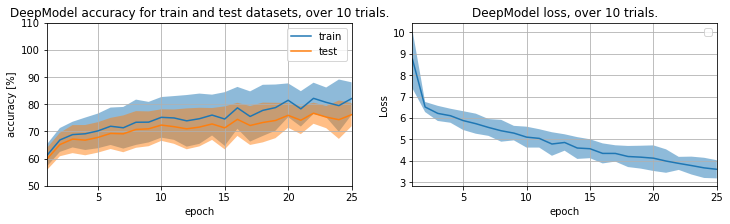

In [23]:
helpers.plot_model_output(trial_train_accuracies_deep, trial_test_accuracies_deep, trial_losses_deep, "DeepModel")

No handles with labels found to put in legend.


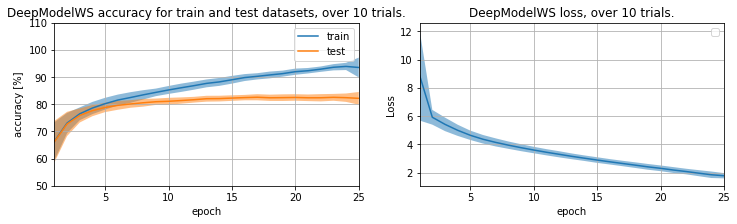

In [24]:
helpers.plot_model_output(trial_train_accuracies_deep_ws, trial_test_accuracies_deep_ws, trial_losses_deep_ws, "DeepModelWS")

No handles with labels found to put in legend.


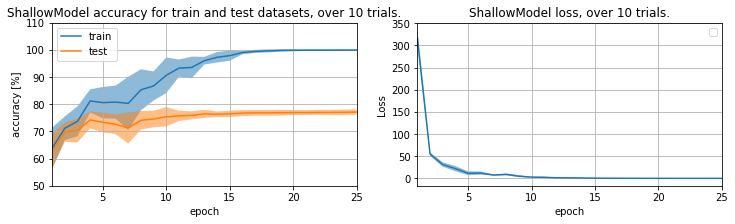

In [25]:
helpers.plot_model_output(trial_train_accuracies_shallow, trial_test_accuracies_shallow, trial_losses_shallow, "ShallowModel")